In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt
from sqlalchemy import func

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func
from sqlalchemy import create_engine, inspect

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
#Column info of Measurement
inspector = inspect(engine)
#inspector.get_table_names()
columns = inspector.get_columns('measurement')
for column in columns:
    print(column["name"], column["type"])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [9]:
# Select and display the first 10 rows of Measurement
engine.execute('SELECT * FROM measurement LIMIT 10').fetchall()

[(1, 'USC00519397', '2010-01-01', 0.08, 65.0),
 (2, 'USC00519397', '2010-01-02', 0.0, 63.0),
 (3, 'USC00519397', '2010-01-03', 0.0, 74.0),
 (4, 'USC00519397', '2010-01-04', 0.0, 76.0),
 (5, 'USC00519397', '2010-01-06', None, 73.0),
 (6, 'USC00519397', '2010-01-07', 0.06, 70.0),
 (7, 'USC00519397', '2010-01-08', 0.0, 64.0),
 (8, 'USC00519397', '2010-01-09', 0.0, 68.0),
 (9, 'USC00519397', '2010-01-10', 0.0, 73.0),
 (10, 'USC00519397', '2010-01-11', 0.01, 64.0)]

In [10]:
#Column info of Station
inspector = inspect(engine)
#inspector.get_table_names()
columns = inspector.get_columns('station')
for column in columns:
    print(column["name"], column["type"])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [11]:
# Select and display the first 10 rows of Station

engine.execute('SELECT * FROM station LIMIT 10').fetchall()


[(1, 'USC00519397', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0),
 (2, 'USC00513117', 'KANEOHE 838.1, HI US', 21.4234, -157.8015, 14.6),
 (3, 'USC00514830', 'KUALOA RANCH HEADQUARTERS 886.9, HI US', 21.5213, -157.8374, 7.0),
 (4, 'USC00517948', 'PEARL CITY, HI US', 21.3934, -157.9751, 11.9),
 (5, 'USC00518838', 'UPPER WAHIAWA 874.3, HI US', 21.4992, -158.0111, 306.6),
 (6, 'USC00519523', 'WAIMANALO EXPERIMENTAL FARM, HI US', 21.33556, -157.71139, 19.5),
 (7, 'USC00519281', 'WAIHEE 837.5, HI US', 21.45167, -157.84888999999998, 32.9),
 (8, 'USC00511918', 'HONOLULU OBSERVATORY 702.2, HI US', 21.3152, -157.9992, 0.9),
 (9, 'USC00516128', 'MANOA LYON ARBO 785.2, HI US', 21.3331, -157.8025, 152.4)]

In [12]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [13]:
# Create our session (link) from Python to the DB
session = Session(engine)
conn = engine.connect()

# Exploratory Climate Analysis

In [14]:
# Design a query to retrieve the last 12 months of precipitation data and plot the data
# Calculate the date 1 year ago from the last data point in the database
prcp_1 = session.query(Measurement.date, Measurement.prcp).\
    filter(Measurement.date.between('2016-08-23', '2017-08-23')).all()
prcp_df = pd.DataFrame(prcp_1,columns=["date","precipitation"])
prcp_df.dropna(how='any', inplace=True)
prcp_df.set_index('date', inplace=True, drop=True)
prcp_df.sort_values(by='date') 
prcp_df.tail()

,precipitation
date,
2017-08-17,0.13
2017-08-19,0.09
2017-08-21,0.56
2017-08-22,0.50
2017-08-23,0.45


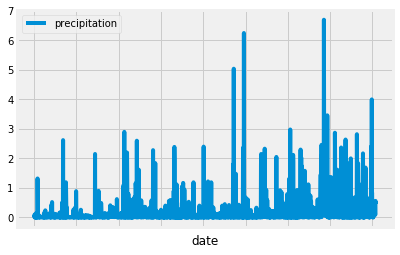

In [15]:
prcp_df.plot()
plt.show()

In [16]:
# Use Pandas to calcualte the summary statistics for the precipitation data
prcp_df.describe()

,precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [17]:
# Method 1: Design a query to show how many stations are available in this dataset?
all_data = pd.read_sql("SELECT * FROM station", conn)
all_data.station.count()

9

In [18]:
# Method 2: Design a query to show how many stations are available in this dataset?
Base = automap_base()
Base.prepare(engine, reflect=True)
Station = Base.classes.station
session = Session(engine)
#results = session.query(Station.station).count()
results = session.query(func.count(Station.station)).all()
results

[(9)]

[(9)]

In [19]:
station_count2 = session.query(Measurement.station,func.count(Measurement.station)).\
        group_by(Measurement.station).order_by(func.count(Measurement.station).desc()).all()
station_count2

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [20]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature most active station?
temperatures_q = session.query(func.min(Measurement.tobs),
                               func.max(Measurement.tobs),
                func.avg(Measurement.tobs),
                ).filter_by(station = "USC00519281").all()
temperatures_q

[(54.0, 85.0, 71.66378066378067)]

[(54.0, 85.0, 71.66378066378067)]

In [21]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
session = Session(engine)
highstation_temp_date = session.query(Measurement.date, Measurement.tobs).filter_by(station = "USC00519281").\
    filter(Measurement.date.between('2016-08-18', '2017-08-18')).all()
highstation_temp_date

[('2016-08-18', 80.0),
 ('2016-08-19', 79.0),
 ('2016-08-20', 81.0),
 ('2016-08-21', 79.0),
 ('2016-08-22', 78.0),
 ('2016-08-23', 77.0),
 ('2016-08-24', 77.0),
 ('2016-08-25', 80.0),
 ('2016-08-26', 80.0),
 ('2016-08-27', 75.0),
 ('2016-08-28', 73.0),
 ('2016-08-29', 78.0),
 ('2016-08-30', 77.0),
 ('2016-08-31', 78.0),
 ('2016-09-01', 80.0),
 ('2016-09-02', 80.0),
 ('2016-09-03', 78.0),
 ('2016-09-04', 78.0),
 ('2016-09-05', 78.0),
 ('2016-09-06', 73.0),
 ('2016-09-07', 74.0),
 ('2016-09-08', 80.0),
 ('2016-09-09', 79.0),
 ('2016-09-10', 77.0),
 ('2016-09-11', 80.0),
 ('2016-09-12', 76.0),
 ('2016-09-13', 79.0),
 ('2016-09-14', 75.0),
 ('2016-09-15', 79.0),
 ('2016-09-16', 78.0),
 ('2016-09-17', 79.0),
 ('2016-09-18', 78.0),
 ('2016-09-19', 78.0),
 ('2016-09-20', 76.0),
 ('2016-09-21', 74.0),
 ('2016-09-22', 77.0),
 ('2016-09-23', 78.0),
 ('2016-09-24', 79.0),
 ('2016-09-25', 79.0),
 ('2016-09-26', 77.0),
 ('2016-09-27', 80.0),
 ('2016-09-28', 78.0),
 ('2016-09-29', 78.0),
 ('2016-09-

In [22]:
# Unpack and save into separate lists
highstation_temp = [int(result[1]) for result in highstation_temp_date]

<function matplotlib.pyplot.show(*args, **kw)>

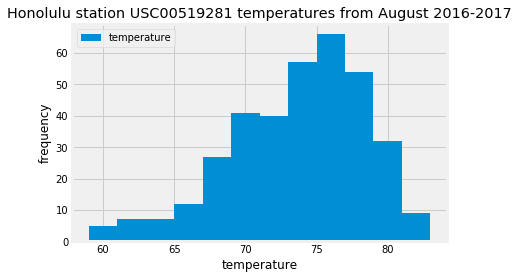

In [23]:
#Plot
plt.hist(highstation_temp, bins=12, label="temperature")
plt.legend()
#plt.grid(True)
plt.ylabel("frequency")
plt.xlabel("temperature")
plt.title("Honolulu station USC00519281 temperatures from August 2016-2017")
plt.show

In [24]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
tripduration = calc_temps('2012-01-28', '2012-02-05')


[(62.0, 69.57142857142857, 74.0)]


In [25]:
tmin, tmax, tavg = calc_temps('2012-01-28', '2012-02-05')[0]
print(tmin, tmax, tavg)

60.0 68.55882352941177 76.0


/Users/charlotteblack/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:445: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


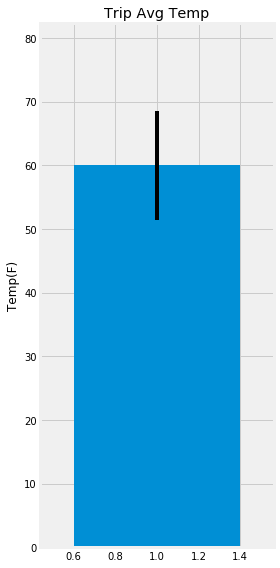

In [26]:
x_p = 1
error = (tmax-tmin) 

fig, ax = plt.subplots(figsize=plt.figaspect(2.))
ax.bar(x_p,tmin, yerr=error)
ax.set_ylabel('Temp(F)')
ax.margins(.2,.2)
#ax.set_xticklabels(x_p)
ax.set_title('Trip Avg Temp')
ax.yaxis.grid(True)
fig.tight_layout()
fig.show()

In [27]:
# Calculate the rainfall per weather station for your trip dates using 
#the previous year's matching dates.
# Sort this in descending order by precipitation 
#amount and list the station, name, latitude, longitude, and elevation
start_date = '2012-01-01'
end_date = '2012-01-07'
rainfall_per_station = session.query(Station.station,Station.name,
                                     Station.latitude, Station.longitude,
                                     Station.elevation,func.sum(Measurement.prcp)).\
    filter(Measurement.station == Station.station).\
    filter(Measurement.date >= start_date).\
    filter(Measurement.date <= end_date)\
    .group_by(Station.name).\
    order_by(func.sum(Measurement.prcp).desc()).all()
rainfall_per_station

[('USC00516128',
  'MANOA LYON ARBO 785.2, HI US',
  21.3331,
  -157.8025,
  152.4,
  0.31),
 ('USC00519281',
  'WAIHEE 837.5, HI US',
  21.45167,
  -157.84888999999998,
  32.9,
  0.25),
 ('USC00518838', 'UPPER WAHIAWA 874.3, HI US', 21.4992, -158.0111, 306.6, 0.1),
 ('USC00513117',
  'KANEOHE 838.1, HI US',
  21.4234,
  -157.8015,
  14.6,
  0.060000000000000005),
 ('USC00511918',
  'HONOLULU OBSERVATORY 702.2, HI US',
  21.3152,
  -157.9992,
  0.9,
  0.0),
 ('USC00514830',
  'KUALOA RANCH HEADQUARTERS 886.9, HI US',
  21.5213,
  -157.8374,
  7.0,
  0.0),
 ('USC00517948', 'PEARL CITY, HI US', 21.3934, -157.9751, 11.9, 0.0),
 ('USC00519397', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0, 0.0),
 ('USC00519523',
  'WAIMANALO EXPERIMENTAL FARM, HI US',
  21.33556,
  -157.71139,
  19.5,
  0.0)]

[('USC00516128', 'MANOA LYON ARBO 785.2, HI US', 21.3331, -157.8025, 152.4, 0.31), ('USC00519281', 'WAIHEE 837.5, HI US', 21.45167, -157.84888999999998, 32.9, 0.25), ('USC00518838', 'UPPER WAHIAWA 874.3, HI US', 21.4992, -158.0111, 306.6, 0.1), ('USC00513117', 'KANEOHE 838.1, HI US', 21.4234, -157.8015, 14.6, 0.060000000000000005), ('USC00511918', 'HONOLULU OBSERVATORY 702.2, HI US', 21.3152, -157.9992, 0.9, 0.0), ('USC00514830', 'KUALOA RANCH HEADQUARTERS 886.9, HI US', 21.5213, -157.8374, 7.0, 0.0), ('USC00517948', 'PEARL CITY, HI US', 21.3934, -157.9751, 11.9, 0.0), ('USC00519397', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0, 0.0), ('USC00519523', 'WAIMANALO EXPERIMENTAL FARM, HI US', 21.33556, -157.71139, 19.5, 0.0)]

## Optional Challenge Assignment

In [28]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic 
#data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, 
        tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), 
           func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", 
            Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

[(62.0, 69.15384615384616, 77.0)]


In [29]:
x1 = daily_normals("01-28") 
x2 = daily_normals("01-29") 
x3 = daily_normals("01-30") 
x4 = daily_normals("01-31") 
x5 = daily_normals("02-01") 
x6 = daily_normals("02-02") 
x7 = daily_normals("02-03") 
x8 = daily_normals("02-04") 
x9 = daily_normals("02-05") 

In [30]:
normals = (x1+x2+x3+x4+x5+x6+x7+x8+x9)
normals

[(62.0, 69.03703703703704, 77.0),
 (64.0, 69.14, 76.0),
 (60.0, 67.12962962962963, 77.0),
 (60.0, 68.47368421052632, 74.0),
 (56.0, 68.14035087719299, 78.0),
 (59.0, 68.85964912280701, 77.0),
 (58.0, 67.79661016949153, 77.0),
 (61.0, 68.14035087719299, 76.0),
 (59.0, 69.6842105263158, 80.0)]

In [31]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings
vac_days = ["01-28","01-29","01-30","01-31","02-01","02-02","02-03", 
    "02-04", "02-05"]
# Loop through the list of %m-%d strings and calculate the 
#normals for each date
normals1 = []
for x in vac_days:
#    x = daily_normals(i)
#    l.append(x)
    normals1.append(daily_normals(x))
normals1

[[(62.0, 69.03703703703704, 77.0)],
 [(64.0, 69.14, 76.0)],
 [(60.0, 67.12962962962963, 77.0)],
 [(60.0, 68.47368421052632, 74.0)],
 [(56.0, 68.14035087719299, 78.0)],
 [(59.0, 68.85964912280701, 77.0)],
 [(58.0, 67.79661016949153, 77.0)],
 [(61.0, 68.14035087719299, 76.0)],
 [(59.0, 69.6842105263158, 80.0)]]

In [32]:
for x in vac_days:
    (daily_normals(x))

In [33]:
#Convert list of list of tuples to list of tuples
normals1_clean = [i[0] for i in normals1]
normals1_clean

[(62.0, 69.03703703703704, 77.0),
 (64.0, 69.14, 76.0),
 (60.0, 67.12962962962963, 77.0),
 (60.0, 68.47368421052632, 74.0),
 (56.0, 68.14035087719299, 78.0),
 (59.0, 68.85964912280701, 77.0),
 (58.0, 67.79661016949153, 77.0),
 (61.0, 68.14035087719299, 76.0),
 (59.0, 69.6842105263158, 80.0)]

[(62.0, 69.15384615384616, 77.0),
 (60.0, 69.39622641509433, 77.0),
 (62.0, 68.9090909090909, 77.0),
 (58.0, 70.0, 76.0),
 (56.0, 67.96428571428571, 76.0),
 (61.0, 68.96491228070175, 76.0),
 (57.0, 68.54385964912281, 76.0)]

In [34]:
# Load the previous query results into a Pandas DataFrame 
#and add the `trip_dates` range as the `date` index
normals_df = pd.DataFrame(normals1_clean,columns=['tmin', 'tavg', 'tmax'])
normals_df
#normals_df.assign(dates=vac_days)
normals_df["Dates"] = vac_days
#normals_df.pivot(index=0, columns=1, values=2)
#normals_df = pd.DataFrame(normals1, columns=['R_Number', 
                                          #   'C_Number', 'Avg', 'Std'])
#normals_df.pivot(index=0, columns=1, values=2)
#normals_df = pd.DataFrame(normals1, columns=['date'])
#normals_df.pivot('date', 'ticker', 'value')
#normals_df = pd.DataFrame([x for x in normals1], columns=columns)
normals_df

,tmin,tavg,tmax,Dates
0,62.0,69.037037,77.0,01-28
1,64.0,69.140000,76.0,01-29
2,60.0,67.129630,77.0,01-30
3,60.0,68.473684,74.0,01-31
4,56.0,68.140351,78.0,02-01
5,59.0,68.859649,77.0,02-02
6,58.0,67.796610,77.0,02-03
7,61.0,68.140351,76.0,02-04
8,59.0,69.684211,80.0,02-05


In [35]:
normals_df.set_index('Dates', inplace=True, drop=True)
normals_df

,tmin,tavg,tmax
Dates,,,
01-28,62.0,69.037037,77.0
01-29,64.0,69.140000,76.0
01-30,60.0,67.129630,77.0
01-31,60.0,68.473684,74.0
02-01,56.0,68.140351,78.0
02-02,59.0,68.859649,77.0
02-03,58.0,67.796610,77.0
02-04,61.0,68.140351,76.0
02-05,59.0,69.684211,80.0


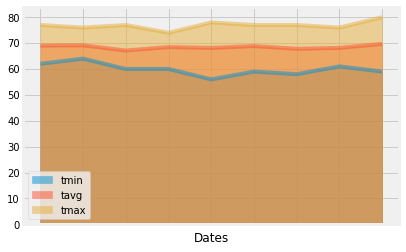

In [36]:
# Plot the daily normals as an area plot with `stacked=False`
#normals_df = pd.DataFrame(np.random.rand(10, 4))
#normals_df.plot.area(stacked=False);
#x = normals_df.index
#ax = normals_df.plot.area(x = normals_df.index,stacked=False)
ax = normals_df.plot.area(stacked=False)
#ax.set_xticklabels(labels, rotation=20)
#ax.set_xticks(normals_df.index)
#ax.set_xticklabels(normals_df.C, rotation=90)

# Step 2

In [37]:

from flask import Flask, jsonify

app = Flask(__name__)

@app.route("/")
def welcome():
#List all available api routes."""
    return (
        f"Available Routes:<br/>"
        f"/api/v1.0/precipitation<br/>"
        f"/api/v1.0/stations<br/>"
    )

#@app.route("/api/v1.0/precipitation")
#def precipitation():
#     for u in session.query(measurement).all():
#      print(u.__dict__)

# 4. Define main behavior
if __name__ == "__main__":
    app.run(debug=True)


 * Serving Flask app "__main__" (lazy loading)
 * Environment: production
   Use a production WSGI server instead.
 * Debug mode: on


 * Running on http://127.0.0.1:5000/ (Press CTRL+C to quit)
 * Restarting with stat


SystemExit: 1

/Users/charlotteblack/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3275: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)
